In [1]:
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import tensorflow as tf

import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure

import numpy as np
import matplotlib.pyplot as plt

train_data, test_data = tfds.load('stl10', 
                        split=['train', 'test'],
                        as_supervised=True, 
                        shuffle_files=True,
                        data_dir=".")

In [2]:
# hog can't accept our TF dataset, so converting to numpy arr
np_imgs = tfds.as_numpy(train_data)

# Using list comprehension to process each image with hog, then convert to np array
hog_imgs = np.array([(hog(x, multichannel=True), l) for x, l in np_imgs])

# Cannot convert this data directly to a tensor due to its shape caused by input and label being together, so I separate them out
input = hog_imgs[0:, 0]
labels = hog_imgs[0:, 1]

# TF didn't like the numpy types, so I convert them to a list and then convert the list back to a tensor for each one
input_tensor = tf.convert_to_tensor(list(input))
labels_tensor = tf.convert_to_tensor(list(labels))

# Combine data back into a dataset
hog_train_data = tf.data.Dataset.from_tensor_slices((input_tensor, labels_tensor))

In [3]:
BATCH_SIZE = 25
#STEPS_PER_EPOCH = len(train_data) / BATCH_SIZE 

def process(img, label):
  return img, tf.one_hot(label, depth=10, dtype=tf.int8)

processed_dataset = hog_train_data.map(process).shuffle(64).batch(BATCH_SIZE)

In [4]:
label_map = ['plane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'primate', 'boat', 'truck']

In [5]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(512, input_shape=[8100]),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation='tanh'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


In [6]:
history = model.fit(processed_dataset, epochs=10)

Train for 200 steps
Epoch 1/10
200/200 [==============================] - 8s 38ms/step - loss: 1.8855 - accuracy: 0.3194
Epoch 2/10
200/200 [==============================] - 7s 34ms/step - loss: 1.5198 - accuracy: 0.4336
Epoch 3/10
200/200 [==============================] - 7s 33ms/step - loss: 1.3748 - accuracy: 0.4932
Epoch 4/10
200/200 [==============================] - 7s 34ms/step - loss: 1.3083 - accuracy: 0.5204
Epoch 5/10
200/200 [==============================] - 7s 33ms/step - loss: 1.2540 - accuracy: 0.5322
Epoch 6/10
200/200 [==============================] - 7s 33ms/step -

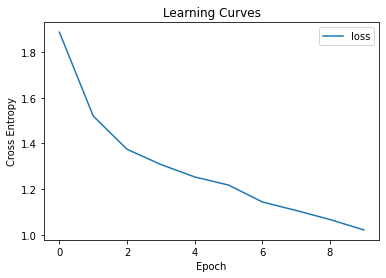

In [7]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

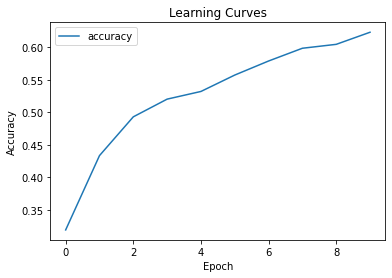

In [9]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               4147712   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 4,415,498
Trainable params: 4,415,498
Non-trainable params: 0
_________________________________________________________________
